In [1]:
import torch
import torchvision

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!unzip gdrive/My\ Drive/boards.zip > /dev/null

In [3]:
best_model = torch.jit.load('gdrive/My Drive/best_model_scripted.pt')
best_model.eval()
best_model = best_model.cpu()

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
import glob

In [5]:
board_file_names = sorted(glob.glob('boards/*.jpeg'))
print(len(board_file_names))

20000


In [6]:
from torch.utils.data import Dataset
from torchvision import datasets
import numpy as np
from torchvision.io import read_image

class BoardDataset(Dataset):
    def __init__(self, board_file_names):
        self.img_paths = board_file_names
    def __len__(self):
        return len(self.img_paths)
    def __getitem__(self, idx):
        path = self.img_paths[idx]
        img = read_image(path)
        label = path[7:-5]
        return img, label

In [7]:
from torch.utils.data import DataLoader

board_data = board_file_names[1000:2000]
board_loader = DataLoader(BoardDataset(board_data), batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 400, 400])
Labels batch shape: 64
torch.Size([3, 400, 400])


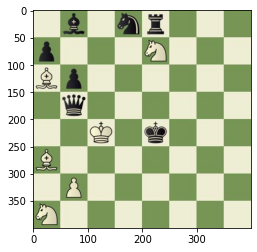

Label: 1b1nr3-p3N3-Bp6-1q6-2K1k3-B7-1P6-N7


In [8]:
board_features, board_labels = next(iter(board_loader))
print(f"Feature batch shape: {board_features.size()}")
print(f"Labels batch shape: {len(board_labels)}")
img = board_features[0]
print(img.size())
label = board_labels[0]
plt.imshow(img.permute(1, 2, 0))
plt.show()
print(f"Label: {label}")

In [9]:
def board_array_to_fen(board_array):
    fen = ''
    for row in range(8):
        counter = 0
        for col in range(8):
            if board_array[row][col] == '-':
                counter += 1
            else:
                if counter != 0:
                    fen += str(counter)
                    counter = 0
                fen += board_array[row][col]
        if counter != 0:
            fen += str(counter)
            counter = 0
        if row != 7:
            fen += '-'
    return fen

In [10]:
label_to_piece = ['-', 'r', 'n', 'b', 'q', 'k', 'p', 'R', 'N', 'B', 'Q', 'K', 'P']

def image_to_predicted_fen(image_tensor):
    board_array = [[' ' for _ in range(8)] for _ in range(8)]

    for row in range(8):
        for col in range(8):
            tile = image_tensor[:, row*50:(row+1)*50, col*50:(col+1)*50].unsqueeze(0).float()
            _, prediction = best_model(tile).max(1)
            board_array[row][col] = label_to_piece[prediction]
    
    return board_array_to_fen(board_array)

print(image_to_predicted_fen(board_features[0]))


1b1nr3-p3N3-Bp6-1q6-2K1k3-B7-1P6-N7


In [11]:
def check_board_accuracy(loader, model):
    num_correct, total = 0, 0
    with torch.no_grad():
        for X, y in loader:
            for i in range(len(y)):
                predicted_fen = image_to_predicted_fen(X[i])
                label = y[i]
                if predicted_fen == label:
                    num_correct += 1
            total += len(y)
            print(f'Correct: {num_correct}, Total: {total}')

check_board_accuracy(board_loader, best_model)


Correct: 61, Total: 64
Correct: 123, Total: 128
Correct: 187, Total: 192
Correct: 248, Total: 256
Correct: 310, Total: 320
Correct: 370, Total: 384
Correct: 432, Total: 448
Correct: 495, Total: 512
Correct: 558, Total: 576
Correct: 619, Total: 640
Correct: 681, Total: 704
Correct: 741, Total: 768
Correct: 803, Total: 832
Correct: 865, Total: 896
Correct: 927, Total: 960
Correct: 966, Total: 1000


In [12]:
from google.colab import files
upload_name = list(files.upload().keys())[0]

Saving Capture.PNG to Capture.PNG


torch.Size([4, 737, 738])


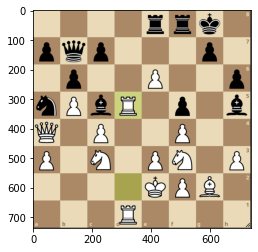

In [13]:
img_tensor = read_image(upload_name)
print(img_tensor.shape)
img_tensor = img_tensor[:3, :, :]
plt.imshow(img_tensor[:3, :, :].permute(1, 2, 0))
plt.show()

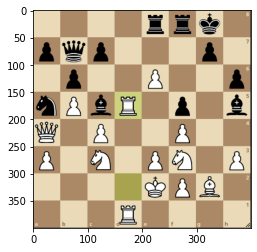

In [14]:
img_tensor_resized = torchvision.transforms.functional.resize(img_tensor, 400)
plt.imshow(img_tensor_resized.permute(1, 2, 0))
plt.show()

In [15]:
print(image_to_predicted_fen(img_tensor_resized))

4rrk1-pqp3p1-1p2P2p-nPbR1p1b-Q1P2P2-P1N1PN1P-4KPB1-3R4


In [16]:
best_model_cpu_scripted = torch.jit.script(best_model)
best_model_cpu_scripted.save('gdrive/My Drive/best_model_cpu_scripted.pt')